In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import torch

from archetypal import UmiTemplateLibrary
from ladybug.epw import EPW 
from lightning.pytorch import Trainer

from ml.data import BuildingDataModule
from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from umi.ubem import UBEM

Couldn't import dot_parser, loading of dot files will not be possible.


c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package energy-pandas is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.8.17
[Taichi] Starting on arch=cuda


In [2]:
bucket = "ml-for-bem"
remote_experiment = "full_climate_zone/v7"
local_data_dir = "data/lightning"

registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v3"
resource = "model.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()

trainer = Trainer(
        accelerator="auto",
        devices="auto",
        strategy="auto",
        enable_progress_bar=True,
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [33]:

gdf = gpd.read_file(Path("data") / "gis" / "Florianopolis_Baseline_sam.zip")

# dict to store key fields for known gis files
id_cols = {
    "florianpolis": {
        "height_col": "HEIGHT",
        "id_col": "OBJECTID",
        "template_name_col": "template_name",
        "wwr_col": "wwr",
    }
}

epw_fp = (
    Path("data")
    / "epws"
    / "global_epws_indexed"
    / "cityidx_0305_MNG_--ULAANBATAAR.442920_IWEC Data.epw"
    # / "cityidx_0007_USA_IL-Chicago Midway.725340_TMY--14819.epw"
)

epw = EPW(epw_fp)
template_lib = UmiTemplateLibrary.open(
    Path("data") / "template_libs" / "BostonTemplateLibrary.json"
)

# Insert dummy template names
gdf[id_cols["florianpolis"]["template_name_col"]] = np.random.choice(
    [t.Name for t in template_lib.BuildingTemplates], size=gdf.shape[0]
)
# insert dummy wwrs
gdf[id_cols["florianpolis"]["wwr_col"]] = 0.4

# gdf.to_file(Path("data") / "gis" / "Florianopolis_Baseline_with_templates_and_wwr.geojson", driver="GeoJSON")

In [4]:
# umi_test = UBEM(
#     gdf=gdf,
#     **id_cols["florianpolis"],
#     epw=epw,
#     template_lib=template_lib,
#     shoebox_width=-1,
#     floor_to_floor_height=4,
#     perim_offset=4,
#     shoebox_gen_type="edge_unshaded"

# )

# umi_test = UBEM.open_umi(Path("C:/Users/szvsw/Downloads/umi_tester_boston.umi"), id_col="id", height_col="Height")
# umi_test = UBEM.open_umi(Path("data") / "gis" / "seed_ulaanbataar.umi", id_col="id", height_col="Height")
umi_test: UBEM = UBEM.open_umi(Path("data") / "gis" / "seed_ulaanbataar.umi", id_col="id", height_col="Height", wwr_col="WwrN")
umi_test.prepare_epw_features(epw=EPW("C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2004-2018.epw"))
features, schedules, climate = umi_test.prepare_for_surrogate()
print("buildings", len(umi_test.gis_features_df), "sbs", len(features))

INFO:UMI:reading input file...
DEBUG:UMI:TEMPORARY LOCATION C:\Users\szvsw\AppData\Local\Temp\tmp06p4x1c7
INFO:UMI:Successfully loaded EPW file Data for [ULAANBATAAR]
DEBUG:UMI:['sdl-common/district_energy_scenarios.json', 'sdl-common/planningSettings.json', 'sdl-common/project.json', 'sdl-common/shoebox-weights.json', 'sdl-common/site-analysis-settings.json', 'sdl-common/ThermalPlantSettings.json', 'sdl-common/ubemio-archetype-id-cache.json', 'sdl-common/ud-results.xml', 'sdl-common/project-settings.json', 'sdl-common/project-header.json', 'Florianopolis_Baseline.3dm', 'cityidx_0305_MNG_--ULAANBATAAR.442920_IWEC Data.epw', 'template-library.json', 'umi.sqlite3']
INFO:UMI:Opening archetpal templates at template-library.json
DEBUG:UMI:Index(['id', 'FloorCount', 'GrossFloorArea', 'Height', 'Name', 'Occupancy',
       'TemplateName', 'UseType', 'WwrE', 'WwrN', 'WwrS', 'WwrW', 'geometry'],
      dtype='object')
INFO:UMI:Read 9.8KB from data\gis\seed_ulaanbataar.umi in 0.02 seconds
INFO:UMI

buildings 93 sbs 1022


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 32/32 [00:00<00:00, 37.33it/s]


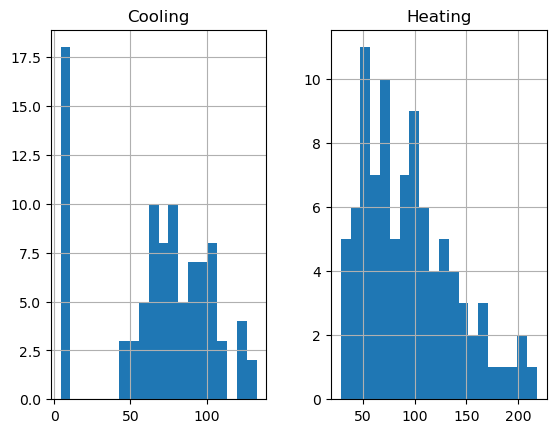

In [26]:

features["WindowShgc"] = 0.75
features["WindowUValue"] = 2
features["VentilationMode"] = 1
features["EquipmentPowerDensity"] = 10
features["LightingPowerDensity"] = 12
features["RoofRValue"] = 10
features["FacadeRValue"] = 10
features["FacadeMass"] = 1
features["RoofMass"] = 1
features["SlabRValue"] = 0.3
features["Infiltration"] = 0.0001
features["wwr"] = 0.64
features[[col for col in features.columns if "shading" not in col]]

torch.set_float32_matmul_precision("medium")
shoebox_predictions, monthly_predictions, annual_predictions = predict_ubem(
        trainer=trainer,
        surrogate=surrogate,
        features=features,
        schedules=schedules,
        climate=climate,
        batch_size=32,
        apply_cops=True
    )

ax = annual_predictions.hist(bins=20)

<Axes: >

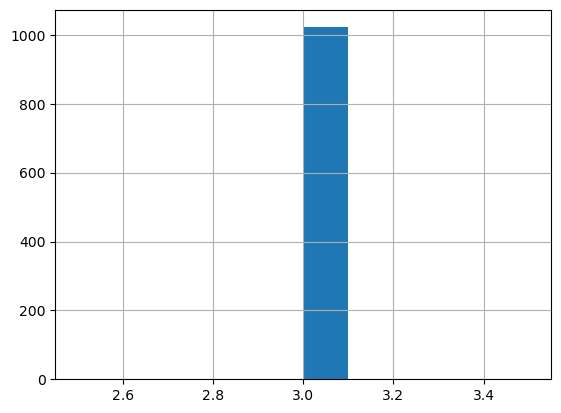

In [30]:
features.height.hist()